In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
# Read in the data
INPUT_DIR = 'm5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [ ]:
stv.head()

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [ ]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

In [ ]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [ ]:
stv.columns[:6]

In [ ]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

In [ ]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [ ]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [ ]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [ ]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [ ]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

In [ ]:
# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

In [15]:
stv_weekly

dept_id      cat_id     store_id  state_id  Date      
FOODS_1      FOODS      CA_1      CA        2011-01-30     473
                                            2011-02-06    2014
                                            2011-02-13    1755
                                            2011-02-20    1599
                                            2011-02-27    1589
                                                          ... 
HOUSEHOLD_2  HOUSEHOLD  WI_3      WI        2016-03-27     620
                                            2016-04-03     669
                                            2016-04-10     549
                                            2016-04-17     684
                                            2016-04-24     573
Name: value, Length: 19180, dtype: int64

In [16]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [17]:
stv_pivot

dept_id    FOODS_1                                                        \
cat_id       FOODS                                                         
store_id      CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA    CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                       
2011-01-30     473   678   631   179   247   386   235   509   343   248   
2011-02-06    2014  2710  2774  1272  1305  1823  1590  1751  1528  1239   
2011-02-13    1755  2737  2561  1259  1399  1933  1663  1503  1812  1195   
2011-02-20    1599  2339  2067  1186  1209  1680  1589  1493  2235  1211   
2011-02-27    1589  2370  2183  1145  1206  1705  1504  1515  1898  1224   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    1868  2922  2380  1309  1307  1494  1252  1612  1639  1088   
2016-04-03    2001  2839  2352  1376  1338  1771  1392  1710  1903  1386   
2016-04-10    2022  2968  2700  1335  1362  1919  1521  1678  2241  1592   
2016-04-17    2441  2693  2600  1294  1481  1835  1411  1824  2370  1510   
2016-04-24    1872  2778  2226  1324  1216  1738  1492  1888  1642  1376   

dept_id    FOODS_2                                                       \
cat_id       FOODS                                                        
store_id      CA_1 CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA   CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                      
2011-01-30    1233  371  1419   628   711   947   837   162   372  1098   
2011-02-06    2699  812  3516  1567  1809  2381  2190  1916  2499  1720   
2011-02-13    3426  776  4313  1844  2025  2687  2588  2134  3464  2574   
2011-02-20    3509  773  4624  1868  2174  2632  2902  2689  5572  2694   
2011-02-27    3056  842  3993  1768  2278  2623  2613  2181  4584  2734   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    2551  813  3684  1615  1715  2451  2034  1893  2856  1959   
2016-04-03    2262  893  3884  1793  2739  2696  2636  1901  3413  2235   
2016-04-10    3348  763  4502  1705  2282  2813  2758  2256  4792  2479   
2016-04-17    2889  794  4021  1678  2452  3121  2950  2193  4541  2825   
2016-04-24    2672  699  3718  1592  2006  2673  2172  1979  3005  1696   

dept_id    FOODS_3                             ... HOBBIES_2                 \
cat_id       FOODS                             ...   HOBBIES                  
store_id      CA_1   CA_2   CA_3  CA_4   TX_1  ...      TX_2 TX_3 WI_1 WI_2   
state_id        CA     CA     CA    CA     TX  ...        TX   TX   WI   WI   
Date                                           ...                            
2011-01-30    3979   2499   5114  1534   2402  ...        38   19   30   12   
2011-02-06   15023   9091  20551  7705  10012  ...       356  370  218  236   
2011-02-13   15701   9134  23482  8002  10646  ...       319  170  142  150   
2011-02-20   16412   9022  25455  7882  11037  ...       134  271  106  110   
2011-02-27   14118   8358  20154  7127  10530  ...       297  219  175  153   
...            ...    ...    ...   ...    ...  ...       ...  ...  ...  ...   
2016-03-27   14776   8597  20869  7630  10423  ...       246  182  144   96   
2016-04-03   17619   9237  20535  8200  10482  ...       318  188  123  153   
2016-04-10   18485  10008  26655  8999  11982  ...       315  191  180  169   
2016-04-17   15744   9444  22670  7910  12189  ...       293  250  188  137   
2016-04-24   15724   9528  21637  8388  10228  ...       400  231  240  182   

dept_id         HOUSEHOLD_1                                                   \
cat_id            HOUSEHOLD                                                    
store_id   WI_3        CA_1  CA_2   CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2   
state_id     WI          CA    CA     CA    CA    TX    TX    TX    WI    WI 

In [18]:
import pandas as pd
import numpy as np
import pymc3 as pm


class data_transform():
    def __init__(self, groups):
        self.g = groups
        self.mu_data = np.mean(self.g['train']['data'], axis=0)
        self.std_data = np.std(self.g['train']['data'], axis=0)

    def std_transf_train(self):
        self.g['train']['data'] = (self.g['train']['data'] - self.mu_data)/self.std_data
        return self.g

    def inv_transf_train(self):
        self.g['train']['data'] = (self.g['train']['data']*self.std_data) + self.mu_data
        return self.g

    def inv_transf_train_general(self, pred):
        pred_samples = pred.shape[0]
        pred = ((pred.reshape(-1, self.g['train']['s'])*self.std_data) + self.mu_data).reshape(pred_samples, self.g['train']['n'], self.g['train']['s'])
        return pred

    def inv_transf_predict_general(self, pred):
        pred_samples = pred.shape[0]
        pred = ((pred.reshape(-1, self.g['predict']['s'])*self.std_data) + self.mu_data).reshape(pred_samples, self.g['predict']['n'], self.g['predict']['s'])
        return pred


def generate_groups_data_flat(y,
                         groups_input,
                         seasonality,
                         h):
    '''
    It works for two kinds of structures:
        1) The name of the columns have specific length for specific groups
        2) There is a multiIndex column structure for each group
    '''
    groups = {}
    for i in ['train', 'predict']:
        if i == 'train':  
            y_ = y.iloc[:-h,:]
        else:
            y_ = y
        groups[i] = {}
        groups[i]['groups_idx'] = {}
        groups[i]['groups_n'] = {}
        groups[i]['groups_names'] = {}

        groups[i]['n'] = y_.shape[0]
        groups[i]['s'] = y_.shape[1]
        n_series = y.columns.unique().shape[0]

        # Test if we are receiving format 1) or 2)
        if len(next(iter(groups_input.values()))) == 1:
            for g in groups_input:
                group_idx = pd.get_dummies(
                        [i[groups_input[g][0]] for i in y_]
                    ).values.argmax(1)
                groups[i]['groups_idx'][g] = np.tile(group_idx, (groups[i]['n'],1)).flatten('F')
                groups[i]['groups_n'][g] = np.unique(group_idx).shape[0]
                group_names = [i[groups_input[g][0]] for i in y_]
                groups[i]['groups_names'][g] = np.unique(group_names)
        else:
            for g in groups_input:
                group_idx = pd.get_dummies(
                        [i[groups_input[g][0]:groups_input[g][1]] for i in y_]
                    ).values.argmax(1)
                groups[i]['groups_idx'][g] = np.tile(group_idx, (groups[i]['n'],1)).flatten('F')
                groups[i]['groups_n'][g] = np.unique(group_idx).shape[0]
                group_names = [i[groups_input[g][0]:groups_input[g][1]] for i in y_]
                groups[i]['groups_names'][g] = np.unique(group_names)

        groups[i]['n_series_idx'] = np.tile(np.arange(groups[i]['s']), (groups[i]['n'],1)).flatten('F')
        groups[i]['n_series'] = np.arange(groups[i]['s'])

        groups[i]['g_number'] = len(groups_input)

        groups[i]['data'] = y_.values.T.ravel()

    groups['seasonality'] = seasonality
    groups['h'] = h

    print("Number of groups: " + str(len(groups['train']['groups_names'])))
    for name,group in groups['train']['groups_names'].items():
        print('\t' + str(name) + ': ' + str(len(group)))
    print('Total number of series: ' + str(groups['train']['s']))
    print('Number of points per series for train: ' + str(groups['train']['n']))
    print('Total number of points: ' + str(groups['predict']['n']))
    print('Seasonality: ' + str(seasonality))
    print('Forecast horizon: ' + str(h))

    return groups


def generate_groups_data_matrix(groups):

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = groups['train']['groups_idx'][group].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
        groups['predict']['groups_idx'][group] = groups['predict']['groups_idx'][group].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    groups['train']['full_data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T
    groups['train']['data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T

    groups['train']['n_series_idx_full'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
    groups['train']['n_series_idx'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]

    groups['predict']['n_series_idx'] = groups['predict']['n_series_idx'].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    return groups


def generate_groups_data_matrix_minibatch(groups,
                                          n_mi,
                                          s_mi):

    groups['train']['n_series_idx'] = pm.Minibatch(groups['train']['n_series_idx'], s_mi)

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = pm.Minibatch(groups['train']['groups_idx'][group], s_mi)

    groups['train']['data'] = pm.Minibatch(groups['train']['data'], ((n_mi,s_mi)))
    
    X = np.arange(groups['train']['n']).reshape(-1,1)
    X_mi = pm.Minibatch(X.ravel(), n_mi).reshape((-1,1))

    return groups, X_mi


In [19]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [20]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=52, h=12)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 262
Total number of points: 274
Seasonality: 52
Forecast horizon: 12


In [21]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np

'''
Features:
1. The levels of the hierarchy that are used in the estimation 
    (i.e. considered to generate new gaussian processes) - 
    fewer levels don't use all the potential information 
    nested in the hierarchies but can boost performance
2. The seasonality to consider (i.e. the periodic 
    kernel defined for the cov function of the GP)
3. Option to define a piecewise function for the GP mean and respective
    selection of the number of changepoints - avoiding the need to apply 
    first differnece to the data
4. Possibility to define a piecewise function outside of the GPs and sum
    their values only in the likelihood
5. Option to use MAP or VI to estimate the parameter values (VI is advised 
    using normal likelihood)
6. Possibility to use Minibatch that ensures scalability of the model
7. Possibility to define a linear kernel to model the linear trend of the data
    avoiding the need to apply first difference to the data
8. Select only partial pooling on the piecewise function
'''

class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        
        if not self.minibatch:
            # with minibatch X is already a theano variable
            X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 a,
                 changepoints,
                 groups,
                 minibatch,
                 n_series,
                 predict=False):
        self.a = a
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch
        self.n_series = n_series.shape[0]
        self.predict = predict

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):

        if not self.minibatch or self.predict:
            # with minibatch, X is already a theano variable
            X = theano.shared(X)

        if self.predict:
            self.n_series = self.g['predict']['s']
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.n_series)) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise + self.a


class HGPforecaster:
    """HGP forecaster
    Parameters
    ----------
    groups_data: dict
                train
                predict
                    'groups_idx'
                    'groups_n'
                    'groups_names'
                    'n'
                    's'
                    'n_series_idx'
                    'n_series'
                    'g_number'
                    'data'
                seasonality
                horizon
    levels: list
                levels to be used in the estimation (default uses all levels)
    changepoints: int
                define a piecewise function as the mean of the GPs based on the number of 
                changepoints defined by the user (uniformly distributed across time)
    n_iterations: int
                number of iterations to run on the optimization (MAP or VI)
    minibatch: list[n_points, n_series]
                list with number of points and number of series to consider
    piecewise_out: bool
            possibility to define a piecewise linear function outside of the GPs definition. It will be summed 
            to the GPs output in the likelihood
    kernel_lin_mean: bool
            possibility to define a linear kernel to model the linear trend of the data avoiding the 
            need to apply first difference to the data
    partial_pool_mean: bool
            select partial pooling on the piecewise function. Defaul to true
    """
    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool_mean = partial_pool_mean

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.series = None

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        # if likelihood is normal standardize data
        self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            # In the case of a normal likelihood we need to define sigma
            self.priors['sigma'] = pm.HalfNormal(
                'sigma',
                0.001,
                shape = self.g['train']['s'])

            if self.piecewise_out:
                # Normal likelihood
                if self.partial_pool_mean:
                    for group in self.levels:
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter

                        # Hyperprior for the mean
                        self.priors["mu_b_%s" %group] = pm.Normal(
                            "mu_b_%s" %group, 
                            mu=0.0, 
                            sd=0.01)
                        self.priors["mu_k_%s" %group] = pm.Normal(
                            'mu_k_%s' %group, 
                            0.0,
                            0.01)
                        self.priors["mu_m_%s" %group] = pm.Normal(
                            'mu_m_%s' %group, 
                            0.0,
                            0.01)
                        self.priors["mu_a_%s" %group] = pm.Normal(
                            'mu_a_%s' %group, 
                            0.0,
                            0.1)                          
                        # Hyperprior for the std
                        self.priors["sd_b_%s" %group] = pm.HalfNormal(
                            "sd_b_%s" %group, 
                            sd=0.01)
                        self.priors["sd_k_%s" %group] = pm.HalfNormal(
                            'sd_k_%s' %group, 
                            0.01)
                        self.priors["sd_m_%s" %group] = pm.HalfNormal(
                            'sd_m_%s' %group, 
                            0.01)
                        self.priors["sd_a_%s" %group] = pm.HalfNormal(
                            'sd_a_%s' %group, 
                            0.01)                                   

                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["mu_b_%s" %group], 
                            self.priors["sd_b_%s" %group],
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["mu_k_%s" %group], 
                            self.priors["sd_k_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["mu_m_%s" %group], 
                            self.priors["sd_m_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                        self.priors["a_%s" %group] = pm.Normal(
                            "a_%s" %group, 
                            self.priors["mu_a_%s" %group], 
                            self.priors["sd_a_%s" %group],
                            shape=self.g['train']['groups_n'][group])
                else:
                    self.priors["k"] = pm.Normal(
                        'k',
                        0.0,
                        0.01,
                        shape = self.g['train']['s'])
                    self.priors["m"] = pm.Normal(
                        'm', 
                        0.0,
                        0.01,
                        shape = self.g['train']['s'])
                    self.priors["b"] = pm.Normal(
                        'b', 
                        0.,
                        0.01,
                        shape = (self.changepoints.shape[0], self.g['train']['s']))                        

            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                # priors for the kernels of each group

                # The inverse gamma is very useful to inform our prior dist of the length scale
                # because it supresses both zero and infinity.
                # The data don't inform length scales larger than the maximum covariate distance 
                # and shorter than the minimum covariate distance (distance between time points which 
                # is always 1 in our case).

                # Parameters expQuad kernel
                self.priors["l_t_%s" %group] = pm.InverseGamma(
                    'l_t_%s' %group, 
                    4, 
                    self.g['train']['n'], 
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_t_%s" %group] = pm.HalfNormal(
                    'eta_t_%s' %group, 
                    1,
                    shape = self.g['train']['groups_n'][group])

                # Parameters periodic kernel
                self.priors["l_p_%s" %group] = pm.HalfNormal(
                    'l_p_%s' %group, 
                    0.5,
                    shape = self.g['train']['groups_n'][group])
                self.priors["eta_p_%s" %group] = pm.HalfNormal(
                    'eta_p_%s' %group, 
                    1.5, 
                    shape = self.g['train']['groups_n'][group])

                # Parameters white noise kernel
                self.priors["sigma_%s" %group] = pm.HalfNormal(
                    'sigma_%s' %group, 
                    0.001,
                    shape = self.g['train']['groups_n'][group])

                if self.piecewise_out:
                    # If piecewise_out is true the piecewise function is defined outside
                    # of the Gaussian processes, therefore nothing is done here
                    pass
                elif np.any(self.changepoints):
                    if self.partial_pool_mean:
                        # Parameters for the piecewise linear function defined as GPs mean functions
                        # with a normal likelihood -> wider intervals as we don't have the log-link
                        # function
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.1)
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group, 
                            0.0,
                            0.1)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.1)                            
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter
                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["hy_b_%s" %group], 
                            0.01,
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["hy_k_%s" %group], 
                            0.01,
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["hy_m_%s" %group], 
                            0.01,
                            shape=self.g['train']['groups_n'][group])
                    else:
                        # Parameters for the piecewise linear function defined as GPs mean functions
                        # with a normal likelihood -> wider intervals as we don't have the log-link
                        # function
                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            0.0,
                            0.05,
                            shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            'k_%s' %group, 
                            0.0,
                            0.1,
                            shape = self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            'm_%s' %group, 
                            0.0,
                            0.1,
                            shape = self.g['train']['groups_n'][group])
                elif self.kernel_lin_mean:
                    # Parameters linear kernel to model the mean of the GP
                    self.priors["c_%s" %group] = pm.Normal(
                        'c_%s' %group, 
                        0, 
                        0.1,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["sigma_l_%s" %group] = pm.HalfNormal(
                        'sigma_l_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])


    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group

                    if self.piecewise_out:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif np.any(self.changepoints):
                        mu_func = PiecewiseLinearChangepoints(intercept = np.zeros(1),
                                                              b = self.priors["b_%s" %group][:, idx],
                                                              changepoints = self.changepoints,
                                                              k = self.priors["k_%s" %group][idx],
                                                              m = self.priors["m_%s" %group][idx],
                                                              groups = self.g,
                                                              minibatch = self.minibatch)

                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])                                
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif self.kernel_lin_mean:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + self.priors["sigma_l_%s" %group][idx]**2 * pm.gp.cov.Linear(1, c=self.priors["c_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    else:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g,
                                                        minibatch = self.minibatch,
                                                        n_series = self.series).build(self.X_mi)
                    
                    piece = sum(piece_.values())
                    self.y_pred = pm.Normal('y_pred', 
                        mu=self.f + piece, 
                        sd=self.priors['sigma'][self.series].reshape((1,-1)),
                        observed=self.g['train']['data'],
                        total_size=(self.g['train']['n'],self.g['train']['s']))
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g,
                                                        minibatch = self.minibatch,
                                                        n_series = self.series).build(self.X)
                    
                    piece = sum(piece_.values())
                    self.y_pred = pm.Normal('y_pred', 
                        mu=self.f + piece, 
                        sd=self.priors['sigma'],
                        observed=self.g['train']['data'])
                else:
                    # normal likelihood without minibatch
                    self.y_pred = pm.Normal('y_pred', 
                            mu=self.f,
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.piecewise_out:
                # normal likelihood with a piecewise function summed
                piece_={}
                for group in self.levels:
                    piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                    m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                    b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                    a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                    changepoints = self.changepoints,
                                                    groups = self.g,
                                                    minibatch = self.minibatch,
                                                    n_series = self.series).build(self.X)

                piece = sum(piece_.values())
                self.prior_like = pm.Normal('prior_like', 
                    mu=piece + self.f, 
                    sd=self.priors['sigma'],
                    shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))

            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.piecewise_out:
                piece_={}
                for group in self.levels:
                    piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    m = self.priors["m_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    b = self.priors['b_%s' %group][:,self.g['predict']['groups_idx'][group]],
                                                    a = self.priors["a_%s" %group][self.g['predict']['groups_idx'][group]],
                                                    changepoints = self.changepoints,
                                                    groups = self.g,
                                                    minibatch = self.minibatch,
                                                    n_series = self.series,
                                                    predict=True).build(X_new)

                piece = sum(piece_.values())
                y_pred_new = pm.Normal("y_pred_new", 
                                mu=f_ + piece,
                                sd=self.priors['sigma'],
                                shape=(n_new, self.g['predict']['s']))
            else:
                y_pred_new = pm.Normal("y_pred_new", 
                                mu=f_, 
                                sd=self.priors['sigma'],
                                shape=(n_new, self.g['predict']['s']))
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                # Sampling using points from MAP
                self.pred_samples_predict = pm.sample_posterior_predictive([self.mp], 
                              vars=[y_pred_new], 
                              samples=500)

        # backtransform the data and predictions to the original scale
        if self.minibatch:   
            self.g['train']['data'] = self.g['train']['full_data'] 
            self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
        else:
            self.g = self.dt.inv_transf_train()
            self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

def visualize_fit(groups, pred_samples_fit, n_series_to_show):
    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    n = groups['train']['n']
    ax = np.ravel(ax)
    for i in range(n_series_to_show):
        ax[i].plot(np.arange(n), pred_samples_fit[:,:,i].T, alpha=0.003, color='orange', label='model fit')
        ax[i].plot(np.arange(n), groups['train']['data'][:,i], label='data')

def visualize_predict(groups, pred_samples_predict, n_bottom_series_to_show, levels=[0,1,2]):
    """
    Parameters
    ----------
    levels: list
                0 -> total, 1 -> groups, 2 -> bottom
                Default to [0,1,2]
    """
    n_series_to_show = n_bottom_series_to_show
    if 0 in levels:
        n_series_to_show += 1 
    if 1 in levels:
        for _,k in groups['predict']['groups_n'].items():
            n_series_to_show += 2 # only show two series of each group aggregate
            
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)
    n = groups['train']['n']
    n_new = groups['predict']['n']
    j = 0
    # Total
    if 0 in levels:
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        y_all_g = np.sum(y_f, axis=1).reshape(-1,1)

        ax[j].fill_between(np.arange(n_new), 
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=2.5),
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=97.5),
                        label='95% CI', alpha=0.1)
        ax[j].plot(np.arange(n_new), 
                np.median(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='tab:blue', alpha=0.7, label='median')
        ax[j].plot(np.arange(n_new), 
                np.mean(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='b', label='mean')
        ax[j].set_ylim(0,max(np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)*1.5))
        ax[j].plot(np.sum(groups['train']['full_data'], axis=1), 
                color='darkorange', label='training data')
        ax[j].plot(np.arange(n, n_new),
                np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)[n:],
                color='r', label='forecasting data')
        ax[j].legend()
        ax[j].set_title('Total: sum of all series')
        j+=1
    if 1 in levels:
        idx_dict_new = {}
        y_all_g = {}
        f_all_g = {}
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        for id_group, group in enumerate(list(groups['predict']['groups_names'].keys())):
            y_g = np.zeros((groups['predict']['n'], 1))
            f_g = np.zeros((500, groups['predict']['groups_names'][group].shape[0]))
                
            y_all_g[group] = {}
            f_all_g[group] = {}
            
            for idx, name in enumerate(groups['predict']['groups_names'][group]):               
                # Only show 2 plots of each group -> change this is to show more
                if idx < 2:
                    g_n = groups['predict']['groups_n'][group]

                    idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

                    y_g = np.sum(idx_dict_new[name].reshape(1,-1)*y_f, axis=1)
                    f_g = np.sum(idx_dict_new[name].reshape(1,-1)*pred_samples_predict, axis=(2))
                    
                    y_all_g[group][name] = y_g
                    f_all_g[group][name] = f_g
                    
                    ax[j].fill_between(np.arange(groups['predict']['n']), 
                                    np.percentile(f_all_g[group][name], axis=0, q=2.5),
                                    np.percentile(f_all_g[group][name], axis=0, q=97.5),
                                    label='95% CI', alpha=0.1)
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.median(f_all_g[group][name], axis=0),
                            color='tab:blue', alpha=0.7, label='median')
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.mean(f_all_g[group][name], axis=0),
                            color='b', label='mean')
                    ax[j].set_ylim(0,max(y_all_g[group][name])*1.5)
                    ax[j].plot(y_all_g[group][name][:groups['train']['n']], 
                            color='darkorange', label='training data')
                    ax[j].plot(np.arange(groups['train']['n'], groups['predict']['n']),
                            y_all_g[group][name][groups['train']['n']:],
                            color='r', label='forecasting data')
                    ax[j].legend()
                    ax[j].set_title(f'Group {group}: {name}')
                    
                    j+=1
    if 2 in levels:
        for i in range(n_bottom_series_to_show-1):
            ax[j].fill_between(np.arange(n_new), 
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=2.5),
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=97.5),
                            label='95% CI', alpha=0.1)
            ax[j].plot(np.arange(n_new), np.median(pred_samples_predict[:,:,i], axis=0), color='tab:blue', alpha=0.7, label='median')
            ax[j].plot(np.arange(n_new), np.mean(pred_samples_predict[:,:,i], axis=0), color='b', label='mean')
            ax[j].set_ylim(0,max(groups['predict']['data'][i*n_new:i*n_new+n_new])*1.5)
            ax[j].plot(groups['train']['full_data'][:,i], color='darkorange', label='training data')
            ax[j].plot(np.arange(n, n_new), groups['predict']['data'][i*n_new+n:i*n_new+n_new], color='r', label='forecasting data')
            ax[j].legend()
            ax[j].set_title(f'Series {i}',)
            j+=1

def traceplot(trace):
    return pm.traceplot(trace, var_names=['~f_'], filter_vars="like")

def model_graph(model):
    return pm.model_graph.model_to_graphviz(model)

def visualize_prior(groups, prior_checks, n_series_to_show):

    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"

    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)

    for i in range(n_series_to_show):
        ax[i].plot(prior_checks['prior_like'][:,:,i].T, color='b', alpha=0.1)
        ax[i].plot(groups['train']['data'][:,i], color='darkorange')
        ax[i].set_ylim(min(min(groups['train']['data'][:,i])*5,0), max(groups['train']['data'][:,i])*5)

def plot_elbo(trace, last_it=80000):
    plt.plot(-trace.hist[-last_it:])
    plt.title(f'ELBO of the last {last_it} iterations')

def plot_gps_components(series, groups, trace):
    g_idx = [g_idx[series] for g_idx in list(groups['predict']['groups_idx'].values())]

    names_g  = [names[g_idx] for g_idx, names in zip(g_idx, list(groups['train']['groups_names'].values()))]

    _, ax = plt.subplots(groups['train']['g_number']+2, 1, figsize=(20, 20))

    ax = ax.ravel()

    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
            'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey',
            'tab:olive']
    ax[0].set_title(f'Sum of all GPs for series {series}, represented by groups {names_g}')

    trace_vi = []
    for i in range(groups['train']['g_number']):
        trace_vi.append(trace[f'f_{names_g[i]}'].T)
    trace_vi = np.asarray(trace_vi)

    sum_gps = np.sum(trace_vi, axis=0)
    ax[0].plot(sum_gps, color='black', alpha=0.1)
    ax[0].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    ax[1].set_title('Stacked representation of the sum of the GPs')
    ax[1].stackplot(np.arange(trace_vi.shape[1]), np.mean(trace_vi, axis=2), colors=color)
    ax[1].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    for i in range(groups['train']['g_number']):
        ax[i+2].plot(trace_vi[i,:,:], color=color[i], alpha=0.1)
        group = list(groups['train']['groups_names'].keys())[i]
        ax[i+2].set_title(f'GP for {group} {names_g[i]}')
        ax[i+2].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

In [23]:
# Instantiate the model class
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

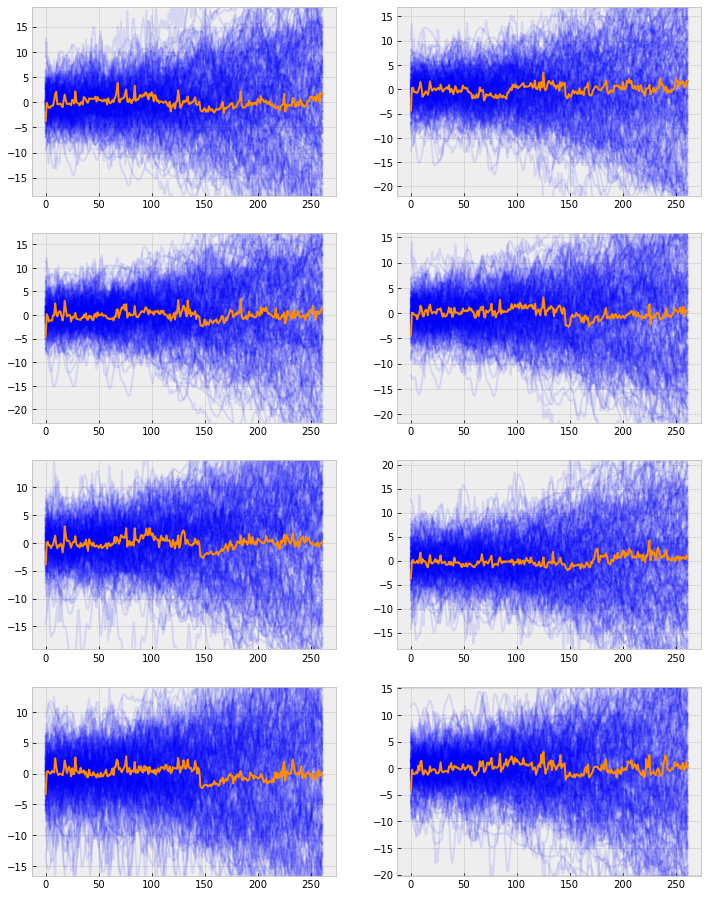

In [24]:
# Prior checks
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [25]:
# Fit and predict
m.fit_vi()
m.predict()

Fitting model...


Finished [100%]: Average Loss = 8.2129e+05


Sampling...


Sampling...


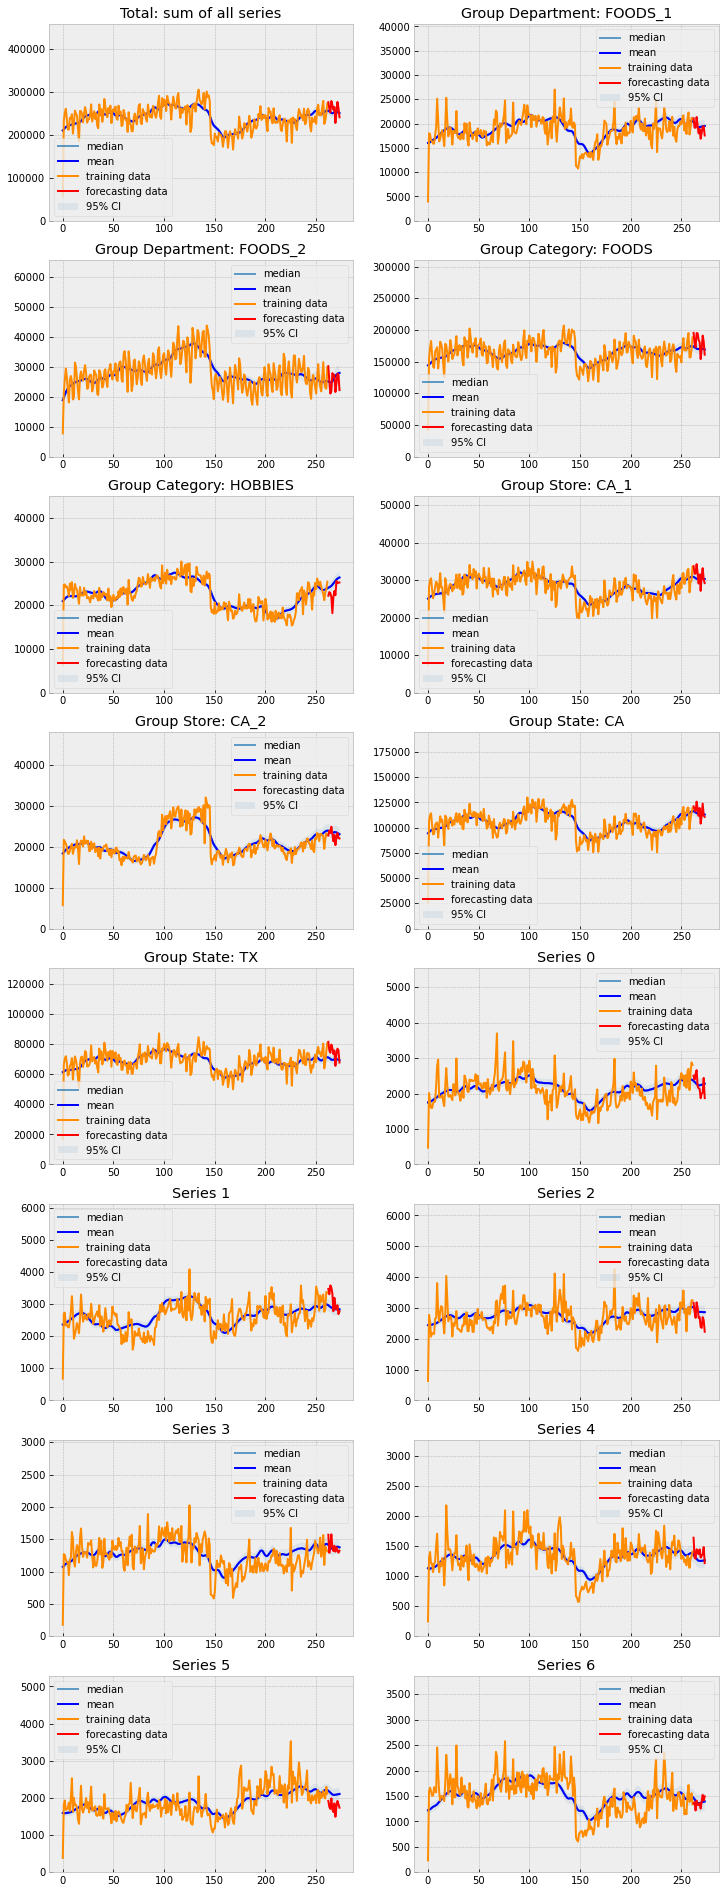

In [26]:
# Visualize your predictions and credible intervals
visualize_predict(groups, m.pred_samples_predict, 8)

In [27]:
import numpy as np
import tabulate
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, display
import pandas as pd


def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


def calculate_metrics(pred_samples,
                      groups):

    pred_s0 = pred_samples.shape[0]
    pred_s1 = pred_samples.shape[1]
    pred_s2 = pred_samples.shape[2]

    pred_samples = pred_samples.reshape(pred_s0, pred_s1*pred_s2, order='F')

    seasonality = groups['seasonality']
    h = groups['h']
    
    n = groups['predict']['n']
    s = groups['predict']['s']
    y_f = groups['predict']['data'].reshape(s, n).T
    y_all_g = {}
    f_all_g = {}
    
    mase_ = {}
    rmse_ = {}
    
    # Bottom
    y_all_g['bottom'] = y_f
    f_all_g['bottom'] = np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]
    
    mase_['bottom'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_f, 
                                     f=np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]),3)
    rmse_['bottom'] = np.round(mean_squared_error(y_f[n-h:n,:], np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], squared=False), 3)

    # Total
    y_all_g['total'] = np.sum(y_f, axis=1).reshape(-1,1)
    f_all_g['total'] = np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1)
    
    mase_['total'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                                     f=np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1))
                            ,3)
    rmse_['total'] = np.round(mean_squared_error(np.sum(y_f, axis=1).reshape(-1,1)[n-h:n,:], 
                                             np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:],axis=1).reshape(-1,1), 
                                             squared=False), 3)

    # Groups
    idx_dict_new = {}
    for group in list(groups['predict']['groups_names'].keys()):
        y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
        f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

        for idx, name in enumerate(groups['predict']['groups_names'][group]):               

            g_n = groups['predict']['groups_n'][group]

            idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

            y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
            f_g[:,idx] = np.sum(idx_dict_new[name]*np.mean(pred_samples, axis=0).reshape(s, n).T, axis=1)[n-h:n]

        y_all_g[group] = np.sum(y_g, axis=1).reshape(-1,1)
        f_all_g[group] = np.sum(f_g, axis=1).reshape(-1,1)

        mase_[group] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_g, 
                                     f=f_g)
                                ,3)

        rmse_[group] = np.round(mean_squared_error(y_g[n-h:n,:], f_g, squared=False), 3)

    # All
    y_all = np.concatenate([y_all_g[x] for x in y_all_g], 1)
    f_all = np.concatenate([f_all_g[x] for x in f_all_g], 1)

    mase_['all'] = np.round(mase(n=n-h, 
                         seas=seasonality, 
                         h=h, 
                         y=y_all, 
                         f=f_all),3)
    rmse_['all'] = np.round(mean_squared_error(y_all[n-h:n,:], f_all, squared=False), 3)
    
    results = {}
    results['mase'] = mase_
    results['rmse'] = rmse_
    return results


def metrics_to_table(metrics):
    metrics_l = []
    metrics_v = []
    for metric_name in metrics:
        metrics_list=[]
        metrics_values=[]
        metrics_list.append('')
        metrics_values.append(metric_name)
        for key, metric in metrics[metric_name].items():
            metrics_list.append(key)
            metrics_values.append(metric)
        metrics_v.append(metrics_values)
    metrics_l.append(metrics_list)
    metrics_l.extend(metrics_v)
    table = metrics_l
    display(HTML(tabulate.tabulate(table, tablefmt='html')))


def metrics_to_latex(groups, metrics):
    metrics_l = []
    metrics_v = []
    for metric_name in metrics:
        metrics_list=[]
        metrics_values=[]
        metrics_list.append('')
        metrics_values.append(metric_name)
        for key, metric in metrics[metric_name].items():
            metrics_list.append(key)
            metrics_values.append(metric)
        metrics_v.append(metrics_values)
    metrics_l.append(metrics_list)
    metrics_l.extend(metrics_v)
    df = pd.DataFrame(metrics_l[1:])
    columns = []
    columns.append('Metrics')
    for i in metrics_l[0][1:]:
        columns.append(i)
    df.columns = columns
    df['Model'] = 'HLGP'
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    return print(df.to_latex(escape=True, index=False))

In [28]:
# Print the overall resuls
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.503,0.369,0.396,0.425,0.464,0.456,0.494
rmse,478.361,16380.771,3593.815,7183.14,2138.249,6066.147,1538.521
